# Synthesization and Anonymization of Multitable Dataset

The purpose of this Notebook is to show how to synthesizer a multitable dataset while preserving the relations between tables.    
For this, we will use Berka dataset which is made of 8 different tables, evolving around the transactions performed by the client of a bank.

The dataset is stored in a MySQL database which can easily be connected to Fabric.

The dataset can be found publicly at: https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions

In [1]:
from IPython.display import SVG, display

Berka consists in 8 tables with several 1-n and n-n relationships.

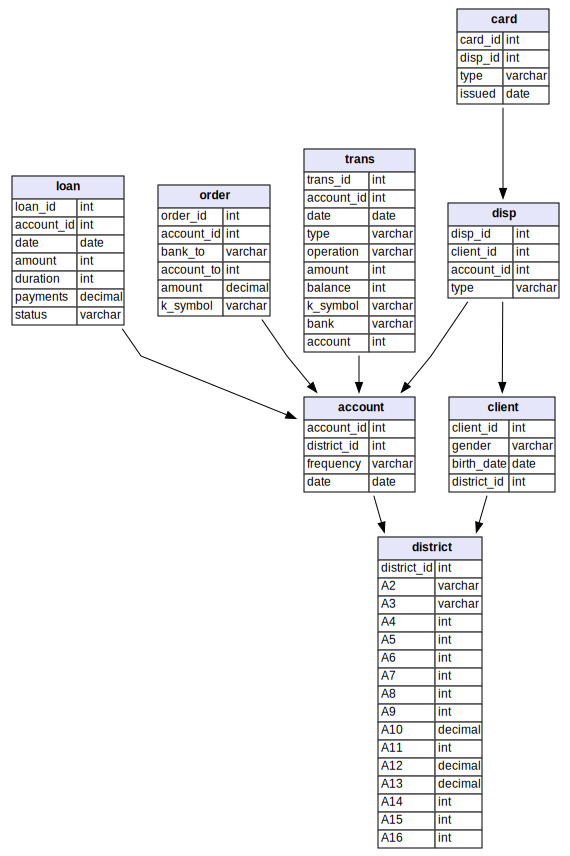

In [2]:
SVG(filename='./berka.svg')

In [3]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.utils.data_types import DataType, VariableType
from ydata.dataset.dataset_type import DatasetType

# Connect to the MySQL database

To access our database, we create a connector instance with the proper URI. The URI depends on the RDMS used to store the data and might slightly differ from the example below that uses MySQL.
In case you use another connector (`Azure`, `Postgre`, `Snowflake`, etc.), please refer to the documentation.

Except for the connection, all connectors expose the same interface such that the rest of this notebook is applicable to any RDMS.

In [4]:
from ydata.connectors.storages.rdbms_connector import MySQLConnector

DB_TYPE = 'mysql'
DB_PYTHON_LIBRARY = 'pymysql'
USERNAME = 'change me'
PASSWORD = 'change me'
HOSTNAME = 'change me'
PORT = '3306'
DATABASE_NAME = 'berka'
URI_STRUCTURE = f"{DB_TYPE}+{DB_PYTHON_LIBRARY}://{USERNAME}:{PASSWORD}@{HOSTNAME}:{PORT}/{DATABASE_NAME}"

conn_str = {
        "hostname":HOSTNAME,
        "username":USERNAME,
        "password": PASSWORD,
        "port": PORT,
        "database": DATABASE_NAME
}
conn = MySQLConnector(conn_string=conn_str)

INFO: 2023-03-10 13:59:00,242 To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO: 2023-03-10 13:59:00,246 State start
INFO: 2023-03-10 13:59:00,259   Scheduler at:     tcp://127.0.0.1:36551
INFO: 2023-03-10 13:59:00,259   dashboard at:            127.0.0.1:8787
INFO: 2023-03-10 13:59:00,308         Start Nanny at: 'tcp://127.0.0.1:43765'
INFO: 2023-03-10 13:59:00,311         Start Nanny at: 'tcp://127.0.0.1:43735'
INFO: 2023-03-10 13:59:00,314         Start Nanny at: 'tcp://127.0.0.1:35271'
INFO: 2023-03-10 13:59:00,319         Start Nanny at: 'tcp://127.0.0.1:41875'
INFO: 2023-03-10 13:59:01,038 Register worker <WorkerState 'tcp://127.0.0.1:42083', name: 0, status: init, memory: 0, processing: 0>
INFO: 2023-03-10 13:59:01,041 Starting worker compute stream, tcp://127.0.0.1:42083
INFO: 2023-03-10 13:59:01,041 Starting established connection to tcp://127.0.0.1:45318
INFO: 2023-03-10 13:59:01,044 Register worker

We can retreive the database schema using `get_database_schema`.

In [5]:
schema = conn.get_database_schema()

2023-03-10 13:59:01,760 INFO sqlalchemy.engine.Engine SELECT DATABASE()
INFO: 2023-03-10 13:59:01,760 SELECT DATABASE()
2023-03-10 13:59:01,761 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:01,761 [raw sql] {}
2023-03-10 13:59:01,841 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
INFO: 2023-03-10 13:59:01,841 SELECT @@sql_mode
2023-03-10 13:59:01,842 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:01,842 [raw sql] {}
2023-03-10 13:59:01,881 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
INFO: 2023-03-10 13:59:01,881 SELECT @@lower_case_table_names
2023-03-10 13:59:01,882 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:01,882 [raw sql] {}
2023-03-10 13:59:02,001 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `berka`
INFO: 2023-03-10 13:59:02,001 SHOW FULL TABLES FROM `berka`
2023-03-10 13:59:02,006 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:02,006 [raw sql] {}
2023-03-10 13:59:02,061 INFO

We now request the entire database.

In [6]:
data = conn.read_database()

2023-03-10 13:59:02,872 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `berka`
INFO: 2023-03-10 13:59:02,872 SHOW FULL TABLES FROM `berka`
2023-03-10 13:59:02,873 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:02,873 [raw sql] {}
2023-03-10 13:59:02,914 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `account`
INFO: 2023-03-10 13:59:02,914 SHOW CREATE TABLE `account`
2023-03-10 13:59:02,916 INFO sqlalchemy.engine.Engine [raw sql] {}
INFO: 2023-03-10 13:59:02,916 [raw sql] {}
2023-03-10 13:59:02,956 INFO sqlalchemy.engine.Engine 
                    select table_schema, table_name, column_name
                    from information_schema.columns
                    where (table_schema, table_name, lower(column_name)) in
                    ((%(table_data_1_1)s, %(table_data_1_2)s, %(table_data_1_3)s));
                
INFO: 2023-03-10 13:59:02,956 
                    select table_schema, table_name, column_name
                    from information_schema.columns

# Update local tables schema

Because Berka database encodes date as `YYMMDD` which looks like a regular integer, the type inference could not deduce it as a date. Therefore, we have to manually specify the datetime format.

In [7]:
data['trans'].astype(column="date", vartype="datetime", format="%y%m%d")
data['account'].astype(column="date", vartype="datetime", format="%y%m%d")
data['loan'].astype(column="date", vartype="datetime", format="%y%m%d")

# Define the dataset attribute and Metadata

The dataset attributes must be specified as a dictionary indexed on the table name. For each table, the possible attributes are the same as for any standard `ydata.metadata.Metadata` object.    
In particular, it is possible to specify for each table the `sortbykey` attribute and if the underlying data is a `timeseries` or a `tabular` dataset. By default, a table is considered `tabular` unless specified otherwise.

For Berka, we configure the table `trans` representing the transactions in the system as `timeseries` with a the `sortbykey` attribute being the column `date`.

In [8]:
from ydata.metadata.multimetadata import MultiMetadata

dataset_attrs = {
    'trans': {
       'sortbykey': 'date'
    }
}

dataset_type = {
    'trans': 'timeseries'
}

m = MultiMetadata(data, dataset_attrs=dataset_attrs, dataset_type=dataset_type)

In [9]:
print(m)

MultiMetadata Summary 
 
Metadata "district" Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 16
Duplicate rows: 1
Target column: 

Column detail: 
   Column    Data type Variable type
0      a1    numerical           int
1      a2       string        string
2      a3  categorical        string
3      a4    numerical           int
4      a5    numerical           int
5      a6    numerical           int
6      a7  categorical           int
7      a8  categorical           int
8      a9  categorical           int
9     a10    numerical         float
10    a11    numerical           int
11    a12       string        string
12    a13  categorical         float
13    a14    numerical           int
14    a15       string        string
15    a16    numerical           int

Warnings: 
       Warning                                                                                                    Columns
0     skewness                                                   

We can check that the type inference was done properly. In particular, the fields `date` are recognized as `DATE/DATETIME` for all tables.

In [10]:
for t, meta in m._metas.items():
    for k,v in meta.columns.items():
        print(t, k, v.datatype, v.vartype)

district a1 DataType.NUMERICAL VariableType.INT
district a2 DataType.STR VariableType.STR
district a3 DataType.CATEGORICAL VariableType.STR
district a4 DataType.NUMERICAL VariableType.INT
district a5 DataType.NUMERICAL VariableType.INT
district a6 DataType.NUMERICAL VariableType.INT
district a7 DataType.CATEGORICAL VariableType.INT
district a8 DataType.CATEGORICAL VariableType.INT
district a9 DataType.CATEGORICAL VariableType.INT
district a10 DataType.NUMERICAL VariableType.FLOAT
district a11 DataType.NUMERICAL VariableType.INT
district a12 DataType.STR VariableType.STR
district a13 DataType.CATEGORICAL VariableType.FLOAT
district a14 DataType.NUMERICAL VariableType.INT
district a15 DataType.STR VariableType.STR
district a16 DataType.NUMERICAL VariableType.INT
account account_id DataType.NUMERICAL VariableType.INT
account district_id DataType.NUMERICAL VariableType.INT
account frequency DataType.CATEGORICAL VariableType.STR
account date DataType.DATE VariableType.DATETIME
client client

## Synthesize the dataset

Synthesizing a multitable dataset is as straightforward as for regular and timeseries synthesizer. However, because a multitable dataset usually lives in a much bigger space than single table, we expose a couple of parameters to guide the synthesizer and manage the memory. In particular, we introduce the concept of **reference table** which refers to the main table in the database according to how you would like to use the synthetic data later on. For instance, Berka is made to represent the transactions of a bank and all the tables evolve around the transactions. By knowing this, we can improve the quality of the relationship learnt by the synthesizer. The argument is optional. 

To manage the memory, we introduce two optional parameters:

1. `reference_table_limit` (optional): in case a reference table is specified and if the `reference_table_limit` is specified, the synthesizer learns over a sample of size `reference_table_limit`.
2. `limit` (optional): number of rows from the denormalized database to be used by the synthesizer during the `fit` process.

Both are optional.

In addition to the memory control, it is possible to anonymize any column of any table. In particular, if a column is a foreign key in a relation with another table, the anonymizer will automatically anonymize all columns in the relationship, even if the name differ. It also possible to request to anonymize primary keys automatically, either for the entire database or for specific tables.

In [11]:
from ydata.preprocessors.methods.anonymization import AnonymizerType
config = {
    'district': {
        'a1': r'[0-9]{4}-[A-Z]{5}' # Will anonymize district.a1 and all its reference accross the database such as account.district_id
    },
    'account': {
        'anonymize_primary_keys': True  # Will anonymize account_id and all its reference accross the database
    },
}

In [12]:
from pathlib import Path
from ydata.synthesizers.multitable.model import MultiTableSynthesizer

if Path('berka.pkl').exists():
    synth = MultiTableSynthesizer.load('berka.pkl')
else:
    synth = MultiTableSynthesizer()
    synth.fit(data, m, anonymize=config, reference_table_limit=135_000)
    synth.save('berka.pkl')

INFO: 2023-03-10 14:00:35,631 [SYNTHESIZER] - Loading SYNTHESIZER state.


## Sample a multitable dataset

In [13]:
sample = synth.sample()

INFO: 2023-03-10 14:00:37,073 [SYNTHESIZER] - Start generating model samples.
INFO: 2023-03-10 14:00:37,074 [SYNTHESIZER] - Sample segment (-0.001, 28203.5]
INFO: 2023-03-10 14:00:37,075 [SYNTHESIZER] - Sample block 0
INFO: 2023-03-10 14:00:44,409 [SYNTHESIZER] - Sample block 1
INFO: 2023-03-10 14:00:51,813 [SYNTHESIZER] - Sample segment (28203.5, 56407.0]
INFO: 2023-03-10 14:00:51,822 [SYNTHESIZER] - Sample block 0
INFO: 2023-03-10 14:00:59,253 [SYNTHESIZER] - Sample block 1
INFO: 2023-03-10 14:01:05,576 [SYNTHESIZER] - Sample segment (56407.0, 84610.5]
INFO: 2023-03-10 14:01:05,587 [SYNTHESIZER] - Sample block 0
INFO: 2023-03-10 14:01:13,099 [SYNTHESIZER] - Sample block 1
INFO: 2023-03-10 14:01:21,244 [SYNTHESIZER] - Sample segment (84610.5, 112814.0]
INFO: 2023-03-10 14:01:21,251 [SYNTHESIZER] - Sample block 0
INFO: 2023-03-10 14:01:28,886 [SYNTHESIZER] - Sample block 1
INFO: 2023-03-10 14:01:37,687 [SYNTHESIZER] - Sample segment (112814.0, 141017.5]
INFO: 2023-03-10 14:01:37,696 [S

# Exploring the multitable sample

Because the sample is a `MultiDataset` object it is possible to access the synthetic table by its name:

In [18]:
data_df = {t:v.to_pandas() for t,v in data.items()}

In [19]:
sample_df = {t:v.to_pandas() for t,v in sample.items()}

## Anonymization

First, we need to check that the the relationships primary keys have been properly anonymized.

We explicitely provided a regular expression to generate the district ID and as we can observe below, the field has been properly anonymized:

In [58]:
data_df['district']['a1'], sample_df['district']['a1']

(0      1
 1      2
 2      3
 3      4
 4      5
       ..
 72    73
 73    74
 74    75
 75    76
 76    77
 Name: a1, Length: 77, dtype: int64,
 0      1707-VQBDV
 1      9199-MIMAZ
 2      7746-SJGMK
 3      0312-YFZCQ
 4      8278-PLZSN
           ...    
 101    5913-OCBZV
 102    8720-LRFNO
 103    0943-TKULY
 104    5884-XLASS
 105    6716-OWTNO
 Name: a1, Length: 106, dtype: string)

As we asked to anonymize **all** primary keys, let's check that they have been properly anonymized as well:

In [56]:
data_df['disp']['account_id'], sample_df['disp']['account_id']

(0           1
 1           2
 2           2
 3           3
 4           3
         ...  
 5364    11349
 5365    11349
 5366    11359
 5367    11362
 5368    11382
 Name: account_id, Length: 5369, dtype: int64,
 0         79413461
 1         28138976
 2         00853045
 3         63946796
 4         03549231
             ...   
 285319    22843526
 285320    32584898
 285321    89011236
 285322    89011236
 285323    81708042
 Name: account_id, Length: 285324, dtype: string)

## Table marginal distribution

To ensure quality of the synthetic table, we first plot the marginal distribution of some features.    
First, we display the marginal distribution for the table `trans` representing the transactions and then for the table `loans`.    
In general, the marginal are really close to the original data which indicate a good quality of the synthetic data.

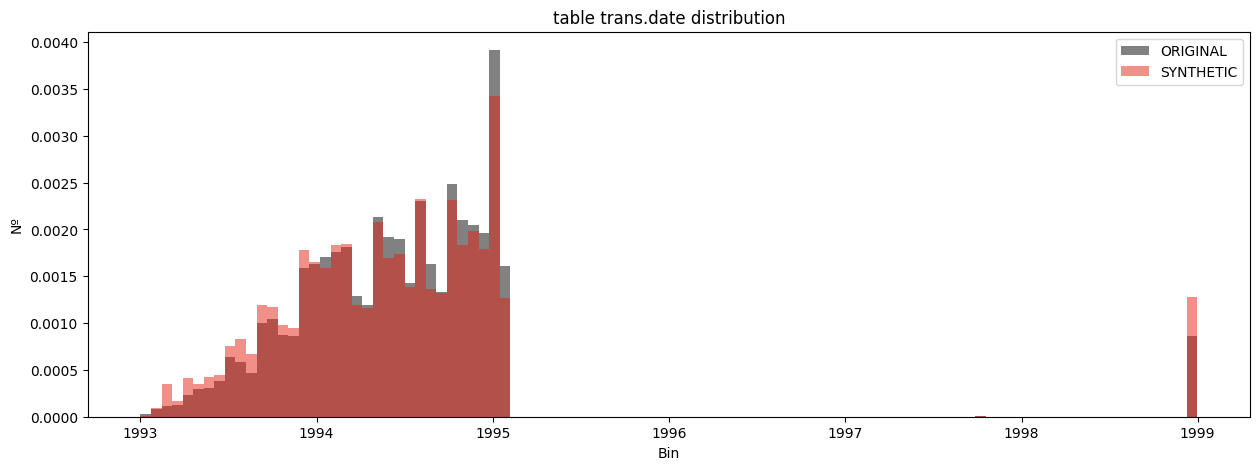

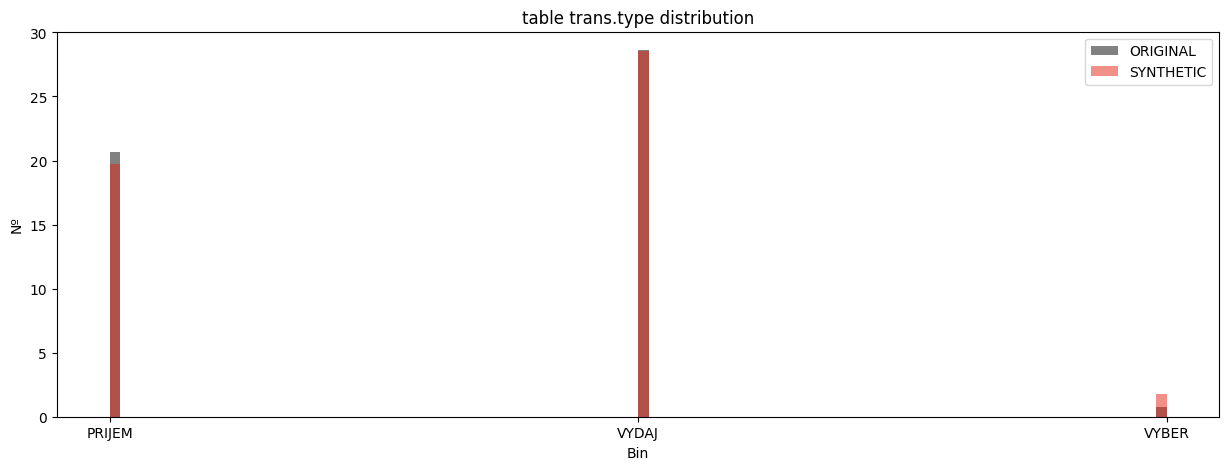

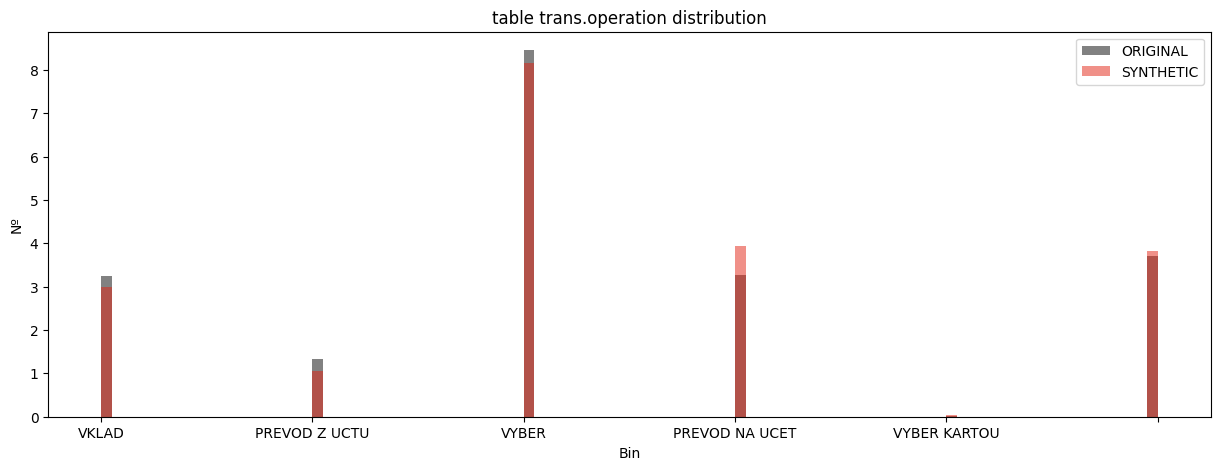

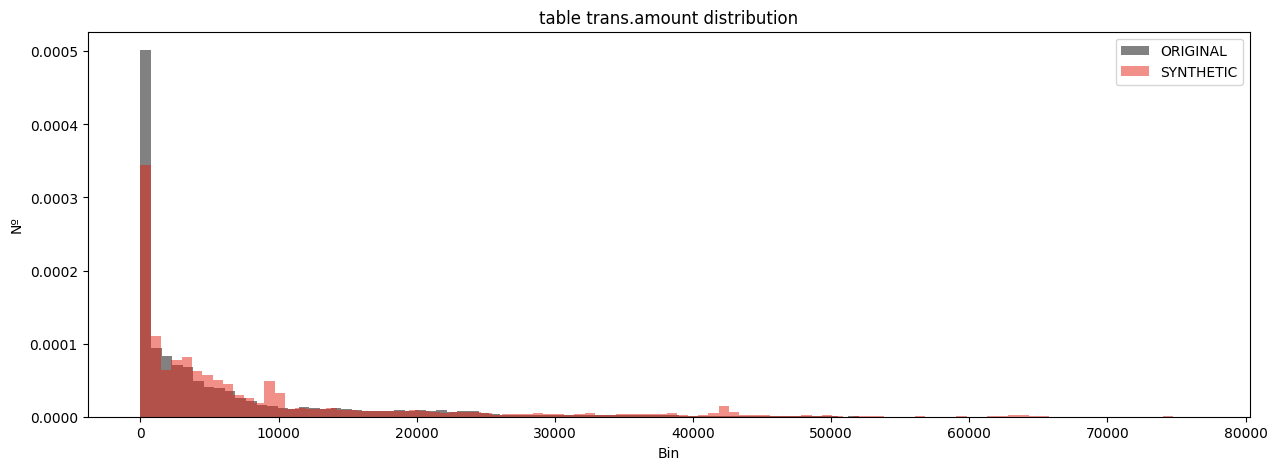

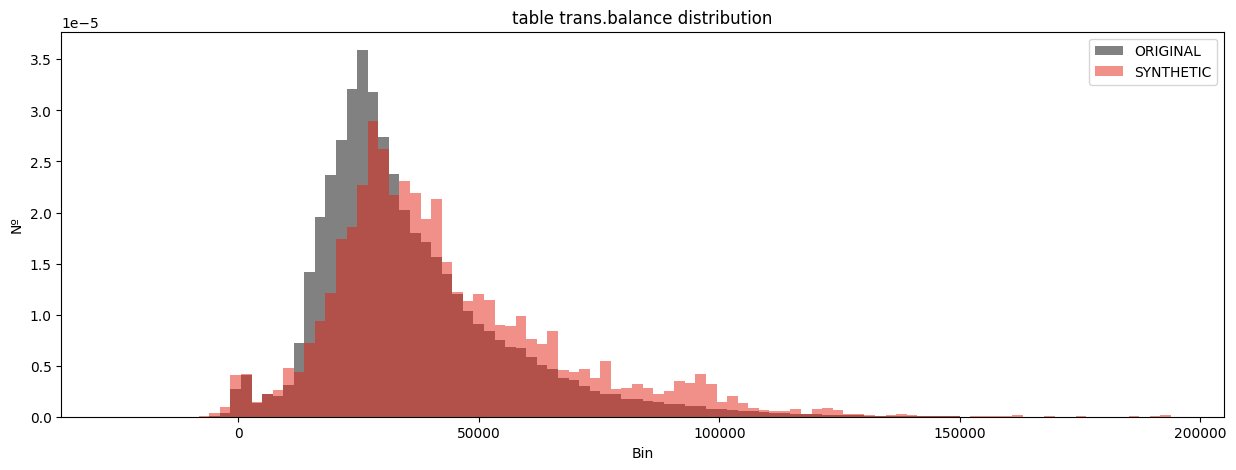

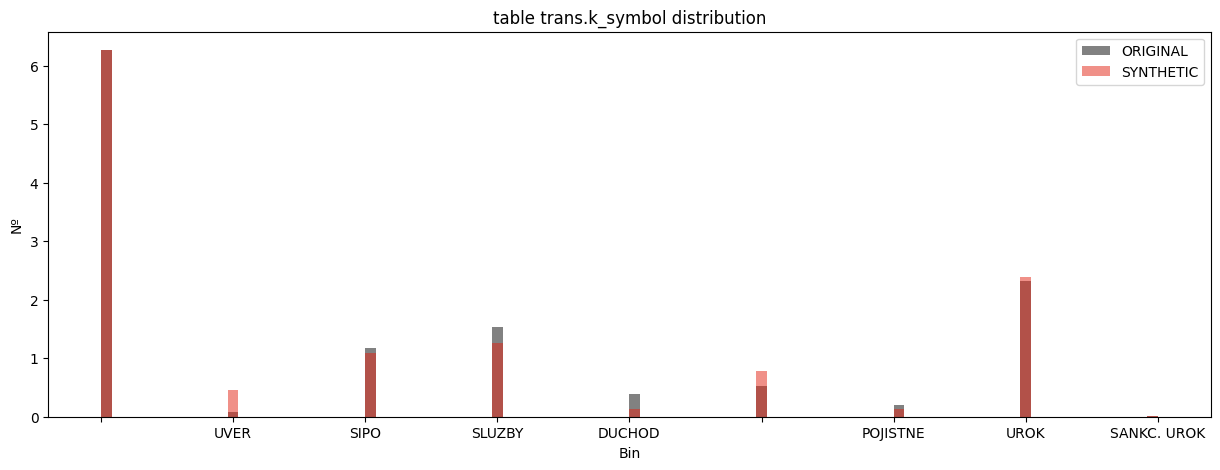

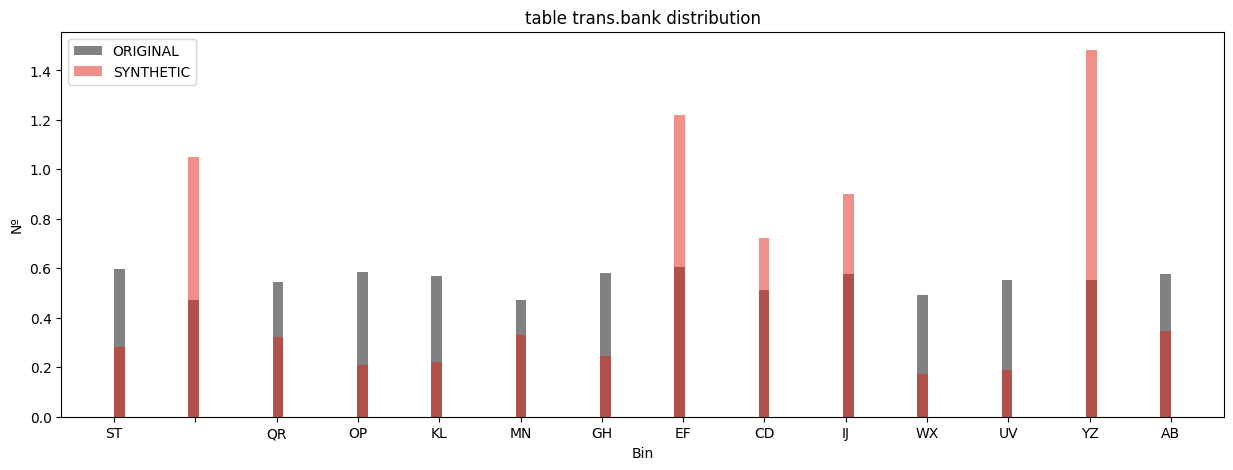

In [124]:
import matplotlib.pyplot as plt
for c in data['trans'].columns:
    if c not in ['account_id', 'trans_id', 'account']:
        plt.figure(figsize=[15, 5])
        plt.title(f"table trans.{c} distribution")
        data_df['trans'][c].hist(color="#040404", label="ORIGINAL", grid=False, bins=100, alpha=0.5, density=True)
        sample_df['trans'][c].hist(color="#E32212", label="SYNTHETIC", grid=False, bins=100, alpha=0.5, density=True)
        plt.xlabel("Bin")
        plt.ylabel("Nº")
        plt.legend()
        plt.show()

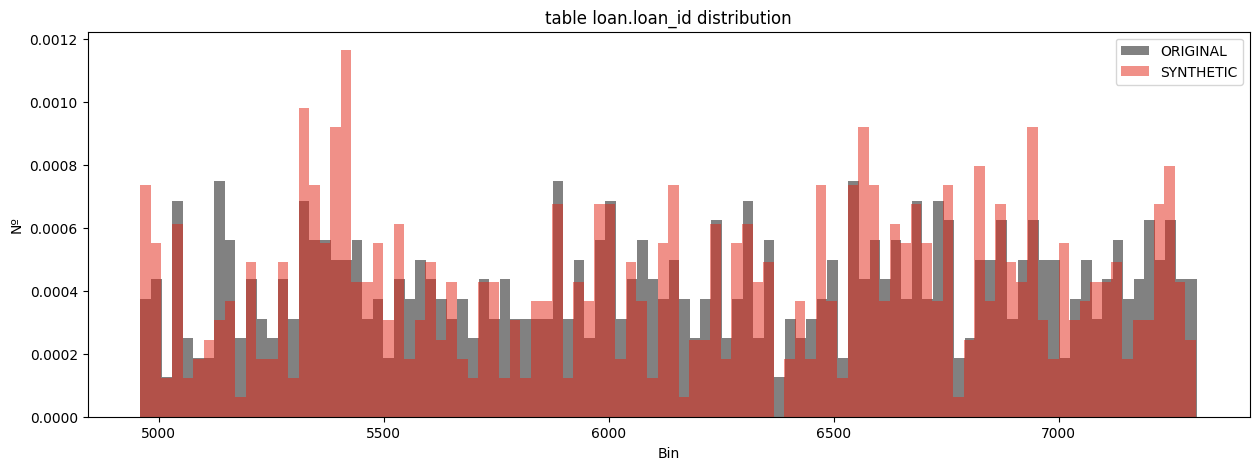

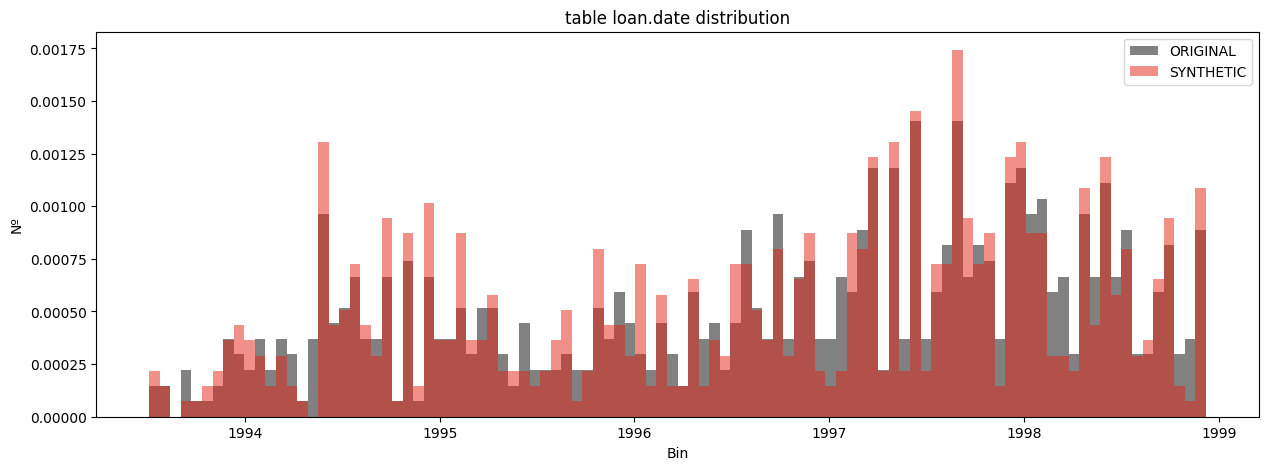

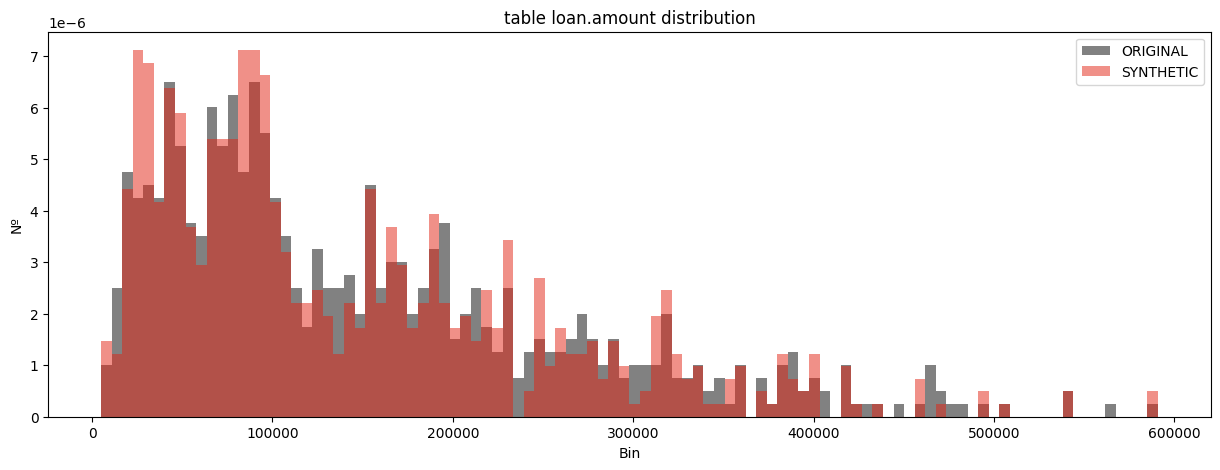

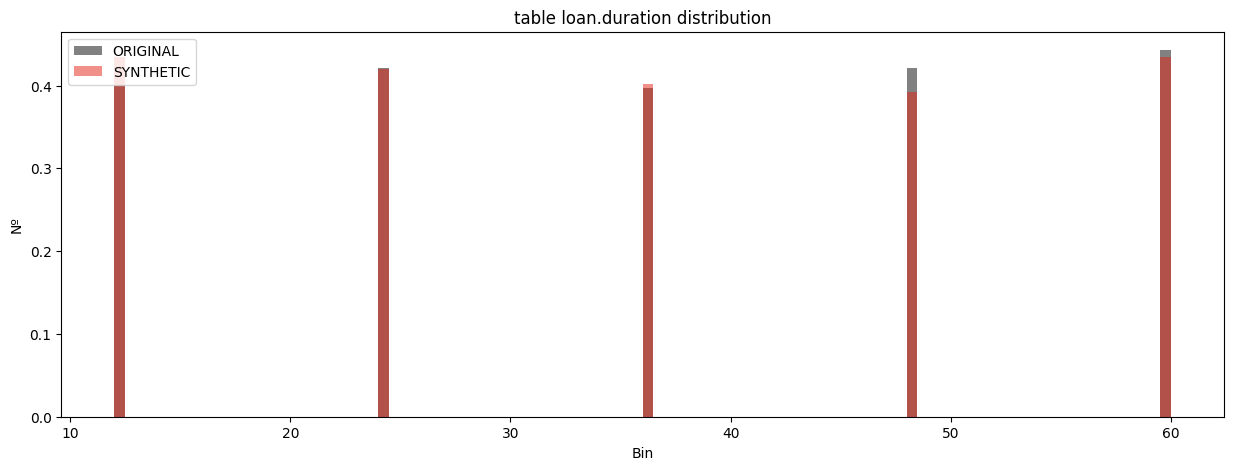

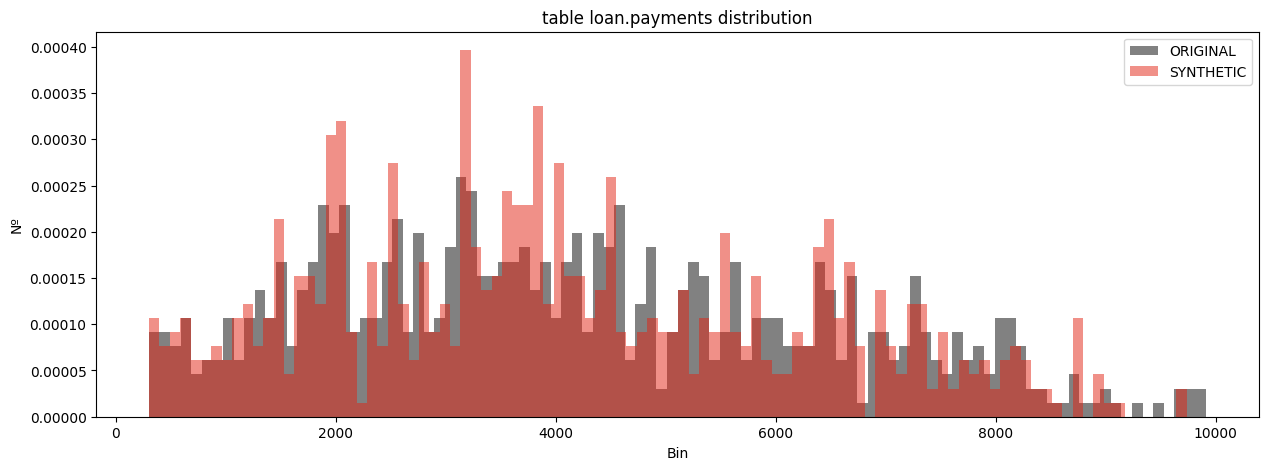

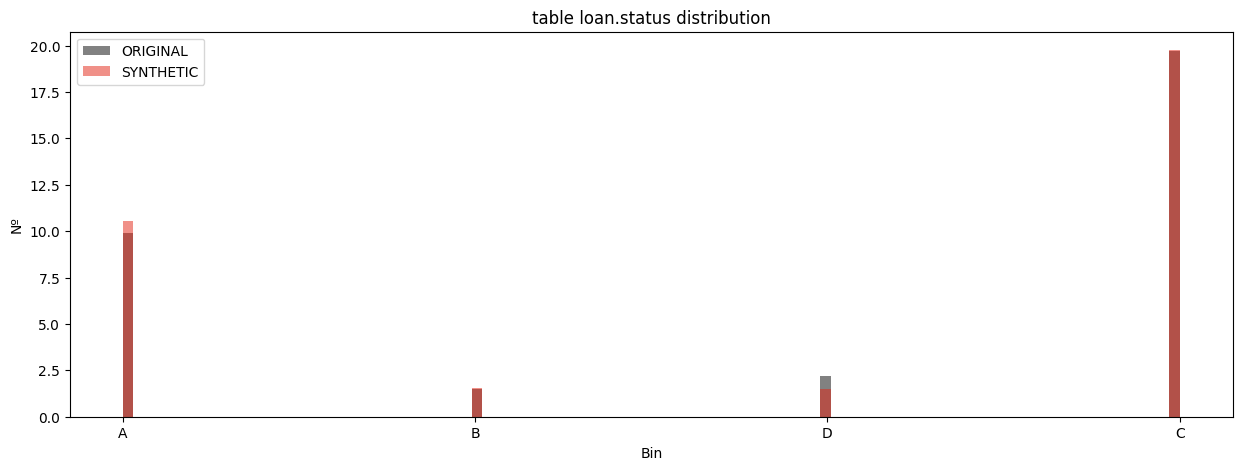

In [125]:
import matplotlib.pyplot as plt
for c in data['loan'].columns:
    if c not in ['account_id']:
        plt.figure(figsize=[15, 5])
        plt.title(f"table loan.{c} distribution")
        data_df['loan'][c].hist(color="#040404", label="ORIGINAL", grid=False, bins=100, alpha=0.5, density=True)
        sample_df['loan'][c].hist(color="#E32212", label="SYNTHETIC", grid=False, bins=100, alpha=0.5, density=True)
        plt.xlabel("Bin")
        plt.ylabel("Nº")
        plt.legend()
        plt.show()

## Relationship Cardinality 

One important metric to preserve in a multitable dataset is the relationship cardinality. When there is a relationship between two tables via, each parent might have several children. The relationship cardinality is the distribution of the number of children in a relationship. To obtain a realistic synthetic database, it is important to ensure that the relationship cardinality is preserve.

In [69]:
dist = {}
for t in ['trans', 'account', 'loan', 'order']:
    for r in schema.tables[t].foreign_keys:
        for fk in r.foreign_keys:
            parent_table = fk.parent.split('.')[0] 
            parent_col = fk.parent.split('.')[1]
            print(t, r.name, parent_table, parent_col)
            dist[(t, r.name, parent_table, parent_col)] = {
                'original': data_df[t][r.name].value_counts(),
                'synthetic': sample_df[t][r.name].value_counts()
            }

trans account_id account account_id
account district_id district a1
loan account_id account account_id
order account_id account account_id


Finally, we display the distribution of cardinality for the relation between `trans` and `account` tables which uses the column `account_id`:

<AxesSubplot: >

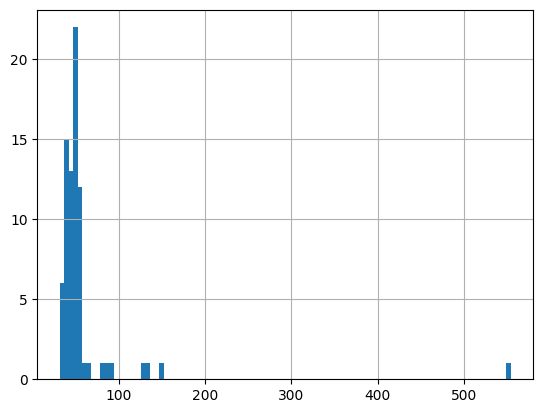

In [122]:
list(dist.items())[1][1]['original'].hist(bins=100)

<AxesSubplot: >

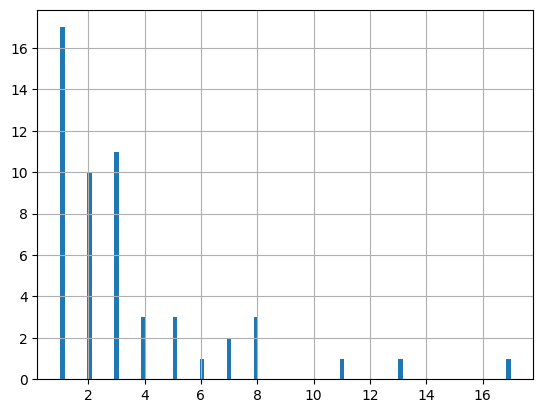

In [123]:
list(dist.items())[1][1]['synthetic'].hist(bins=100)